## Topic Analysis of Review Data

#### DESCRIPTION

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon and the topics that customers are talking about. You will perform topic modeling on specific parts of speech. You’ll finally interpret the emerging topics.

#### Problem Statement: 

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

**Domain:** Amazon reviews for a leading phone brand

#### Analysis to be done: 
POS tagging, topic modeling using LDA, and topic interpretation

**Dataset:** ‘K8 Reviews v0.2.csv’

**Sentiment:** The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)

**Reviews:** The main text of the review

#### Steps to perform:

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.

Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. Finally, give business-friendly names to the topics and make a table for business.

#### Tasks: 

1. Read the .csv file using Pandas. Take a look at the top few records.

2. Normalize casings for the review text and extract the text into a list for easier manipulation.

3. Tokenize the reviews using NLTKs word_tokenize function.

4. Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

5. For the topic model, we should  want to include only nouns.

  - Find out all the POS tags that correspond to nouns.

  - Limit the data to only terms with these tags.

6. Lemmatize. 

  - Different forms of the terms need to be treated as one.

  - No need to provide POS tag to lemmatizer for now.

7. Remove stopwords and punctuation (if there are any). 

8. Create a topic model using LDA on the cleaned up data with 12 topics.

  - Print out the top terms for each topic.

  - What is the coherence of the model with the c_v metric?

9. Analyze the topics through the business lens.

  - Determine which of the topics can be combined.

10. Create topic model using LDA with what you think is the optimal number of topics

  - What is the coherence of the model?

11. The business should  be able to interpret the topics.

  - Name each of the identified topics.

  - Create a table with the topic name and the top 10 terms in each to present to the  business.

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
import gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

#### 1. Read the data

In [2]:
data = pd.read_csv('K8 Reviews v0.2.csv')

In [3]:
data.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14675 entries, 0 to 14674
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  14675 non-null  int64 
 1   review     14675 non-null  object
dtypes: int64(1), object(1)
memory usage: 229.4+ KB


#### 2. Normalizing the casing to lower

In [5]:
data['review_cleaned'] = data['review'].apply(lambda review: review.lower())

In [6]:
data.head()

,sentiment,review,review_cleaned
0,1,Good but need updates and improvements,good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr...","worst mobile i have bought ever, battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...,when i will get my 10% cash back.... its alrea...
3,1,Good,good
4,0,The worst phone everThey have changed the last...,the worst phone everthey have changed the last...


#### 3. Tokenize the reviews using NLTKs word_tokenize function.

In [7]:
reviews = data['review_cleaned']
reviews = [nltk.word_tokenize(review) for review in reviews]

In [8]:
len(reviews)

14675

In [9]:
pprint(reviews[:5], compact=True)

[['good', 'but', 'need', 'updates', 'and', 'improvements'],
 ['worst', 'mobile', 'i', 'have', 'bought', 'ever', ',', 'battery', 'is',
  'draining', 'like', 'hell', ',', 'backup', 'is', 'only', '6', 'to', '7',
  'hours', 'with', 'internet', 'uses', ',', 'even', 'if', 'i', 'put', 'mobile',
  'idle', 'its', 'getting', 'discharged.this', 'is', 'biggest', 'lie', 'from',
  'amazon', '&', 'lenove', 'which', 'is', 'not', 'at', 'all', 'expected', ',',
  'they', 'are', 'making', 'full', 'by', 'saying', 'that', 'battery', 'is',
  '4000mah', '&', 'booster', 'charger', 'is', 'fake', ',', 'it', 'takes', 'at',
  'least', '4', 'to', '5', 'hours', 'to', 'be', 'fully', 'charged.do', "n't",
  'know', 'how', 'lenovo', 'will', 'survive', 'by', 'making', 'full', 'of',
  'us.please', 'don', ';', 't', 'go', 'for', 'this', 'else', 'you', 'will',
  'regret', 'like', 'me', '.'],
 ['when', 'i', 'will', 'get', 'my', '10', '%', 'cash', 'back', '...', '.',
  'its', 'already', '15', 'january..'],
 ['good'],
 ['the', 

#### 4. Perform parts-of-speech tagging on each document using the NLTK POS tagger

In [10]:
%%time
review_pos_tags = [nltk.pos_tag(doc) for doc in reviews]
pprint(review_pos_tags[:5], compact=True)

[[('good', 'JJ'), ('but', 'CC'), ('need', 'VBP'), ('updates', 'NNS'),
  ('and', 'CC'), ('improvements', 'NNS')],
 [('worst', 'JJS'), ('mobile', 'NN'), ('i', 'NN'), ('have', 'VBP'),
  ('bought', 'VBN'), ('ever', 'RB'), (',', ','), ('battery', 'NN'),
  ('is', 'VBZ'), ('draining', 'VBG'), ('like', 'IN'), ('hell', 'NN'),
  (',', ','), ('backup', 'NN'), ('is', 'VBZ'), ('only', 'RB'), ('6', 'CD'),
  ('to', 'TO'), ('7', 'CD'), ('hours', 'NNS'), ('with', 'IN'),
  ('internet', 'JJ'), ('uses', 'NNS'), (',', ','), ('even', 'RB'), ('if', 'IN'),
  ('i', 'JJ'), ('put', 'VBP'), ('mobile', 'JJ'), ('idle', 'NN'),
  ('its', 'PRP$'), ('getting', 'VBG'), ('discharged.this', 'NN'), ('is', 'VBZ'),
  ('biggest', 'JJS'), ('lie', 'NN'), ('from', 'IN'), ('amazon', 'NN'),
  ('&', 'CC'), ('lenove', 'NN'), ('which', 'WDT'), ('is', 'VBZ'), ('not', 'RB'),
  ('at', 'IN'), ('all', 'DT'), ('expected', 'VBN'), (',', ','), ('they', 'PRP'),
  ('are', 'VBP'), ('making', 'VBG'), ('full', 'JJ'), ('by', 'IN'),
  ('saying', 'V

#### 5. Including only nouns for building the Topic Model

In [11]:
review_nouns = [[token for token, pos in doc if pos.startswith('NN')] for doc in review_pos_tags]
pprint(review_nouns[:5], compact=True)

[['updates', 'improvements'],
 ['mobile', 'i', 'battery', 'hell', 'backup', 'hours', 'uses', 'idle',
  'discharged.this', 'lie', 'amazon', 'lenove', 'battery', 'charger', 'hours',
  'don'],
 ['i', '%', 'cash', 'january..'], [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]


#### 6. Lemmatize

In [12]:
%%time
review_lemmatized = [[nltk.stem.WordNetLemmatizer().lemmatize(token) for token in doc] for doc in review_nouns]
pprint(review_lemmatized[:5])

[['update', 'improvement'],
 ['mobile',
  'i',
  'battery',
  'hell',
  'backup',
  'hour',
  'us',
  'idle',
  'discharged.this',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour',
  'don'],
 ['i', '%', 'cash', 'january..'],
 [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]
Wall time: 1.79 s


#### 7. Remove stopwords and punctuation (if there are any).

In [13]:
%%time
review_no_sw = [[token for token in doc if token not in nltk.corpus.stopwords.words('english') 
                 and token.isalpha()] 
                for doc in review_lemmatized]
pprint(review_no_sw[:5])

[['update', 'improvement'],
 ['mobile',
  'battery',
  'hell',
  'backup',
  'hour',
  'us',
  'idle',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour'],
 ['cash'],
 [],
 ['phone', 'everthey', 'phone', 'problem', 'amazon', 'phone', 'amazon']]
Wall time: 16.5 s


#### 8. Create a topic model using LDA on the cleaned up data with 12 topics.

In [14]:
# Build a Dictionary - association word to numeric id
dictionary = gensim.corpora.Dictionary(review_no_sw)
# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in review_no_sw]

In [15]:
NUM_TOPICS = 12
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

#### 8.1 Print out the top terms for each topic.

In [16]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    pprint("Topic #{}: {}".format(idx, lda_model.print_topic(idx, 10)), compact=True)

LDA Model:
('Topic #0: 0.356*"phone" + 0.082*"price" + 0.050*"feature" + 0.036*"battery" '
 '+ 0.029*"range" + 0.022*"backup" + 0.019*"camera" + 0.018*"processor" + '
 '0.017*"performance" + 0.011*"note"')
('Topic #1: 0.122*"phone" + 0.049*"note" + 0.033*"lenovo" + 0.027*"battery" + '
 '0.026*"month" + 0.025*"hr" + 0.024*"budget" + 0.023*"data" + 0.017*"call" + '
 '0.016*"day"')
('Topic #2: 0.060*"note" + 0.047*"screen" + 0.033*"display" + 0.031*"hai" + '
 '0.031*"ram" + 0.029*"glass" + 0.029*"quality" + 0.022*"phone" + '
 '0.021*"smartphone" + 0.020*"gb"')
('Topic #3: 0.048*"phone" + 0.048*"time" + 0.033*"system" + '
 '0.030*"replacement" + 0.024*"day" + 0.024*"sensor" + 0.022*"piece" + '
 '0.021*"notification" + 0.020*"box" + 0.019*"super"')
('Topic #4: 0.047*"feature" + 0.034*"product" + 0.030*"sim" + 0.030*"cast" + '
 '0.030*"screen" + 0.030*"thanks" + 0.029*"quality" + 0.028*"phone" + '
 '0.027*"card" + 0.026*"everything"')
('Topic #5: 0.058*"phone" + 0.030*"day" + 0.026*"delivery

In [17]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.033391  0.103547       1        1  17.578354
9     -0.189607  0.072339       2        1  11.113485
5     -0.041214  0.067130       3        1   9.879890
0     -0.088082  0.056544       4        1   9.723360
7     -0.076643 -0.007183       5        1   9.340488
1     -0.095085 -0.015505       6        1   8.475408
6      0.167004  0.098671       7        1   7.366282
2      0.087270 -0.008064       8        1   6.856510
3     -0.069108 -0.032581       9        1   6.247313
10     0.201154  0.011558      10        1   4.654374
4      0.143622  0.003304      11        1   4.423647
11    -0.005919 -0.349759      12        1   4.340886, topic_info=        Term         Freq        Total Category  logprob  loglift
11    mobile  1556.000000  1556.000000  Default  30.0000  30.0000
47   product  2151.000000  2151.000000  Default  29.0000  29.0000
15     phone  6974.000000  6974.000000  Default  28.0000  28.0000
55    camera  3213.000000  3213.000000  Default  27.0000  27.0000
4    battery  3182.000000  3182.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
15     phone   154.836182  6974.265625  Topic12  -3.1141  -0.6705
16   problem    81.500031  1590.612671  Topic12  -3.7559   0.1658
310  compare    32.583836    77.728729  Topic12  -4.6726   2.2677
24      note    37.480560  1173.884888  Topic12  -4.5326  -0.3072
177     apps    29.218428   189.386169  Topic12  -4.7817   1.2681

[727 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1367      8  0.967683        aap
1328      1  0.962471     access
332       8  0.655486  accessory
332      11  0.315604  accessory
1151      7  0.952301         ad
...     ...       ...        ...
26        8  0.059053       year
26       12  0.014763       year
902       4  0.782617        yes
1024      1  0.964953  yesterday
1770      1  0.975402       zoom

[1945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 6, 1, 8, 2, 7, 3, 4, 11, 5, 12])

#### 8.2 coherence of the model with the c_v metric

In [18]:
# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_no_sw, dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5350791947861054


#### 9. Analyze the topics through the business lens - Determine which of the topics can be combined

Now since the problem at hand demands identifying the diffrent aspects of the budget smartphone launched in the market, it is imperative that the tokens (words in the customer reviews) like 'phone', 'mobile' etc. or sentimental keys like 'problem', 'issue' may be removed from the topic model. That way topic model focuses on the variety of aspects like 'camera', 'battery'.

In [19]:
custom_stop_words = ['phone', 'problem', 'issue', 'product', 'mobile']

review_no_custom_sw = [[token for token in doc if token not in custom_stop_words] for doc in review_no_sw]

pprint(review_no_custom_sw[:5])

[['update', 'improvement'],
 ['battery',
  'hell',
  'backup',
  'hour',
  'us',
  'idle',
  'lie',
  'amazon',
  'lenove',
  'battery',
  'charger',
  'hour'],
 ['cash'],
 [],
 ['everthey', 'amazon', 'amazon']]


In [20]:
%%time
# Build a Dictionary - association word to numeric id
dictionary = gensim.corpora.Dictionary(review_no_custom_sw)

# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in review_no_custom_sw]

#Creating the LDA model
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

#Calculating the cohenrence score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_no_custom_sw, dictionary=dictionary, coherence='c_v')

#Collecting the score in tuple
coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score after removing custom stop words: ', coherence_lda)

Coherence Score after removing custom stop words:  0.5087590858784453
Wall time: 7.42 s


There is only a marginal improvement in the cv score, hence we need to search the parameter space for number of topics for the optimal cv score.

#### 10. Create topic model using LDA with what you think is the optimal number of topics

For finding the optimal we would use two approaches:
    1. Compare the CV score in gensim model tweaking the number of topics
    2. Using sklearn LDA model and using GRidSearch over n_components parameter space

#### Gensim Model for finding the optimal number of topics

In [21]:
%%time
NUM_TOPICS = range(5,13)
coherence_lda_scores = []

for topic in NUM_TOPICS:
    # Build a Dictionary - association word to numeric id
    dictionary = gensim.corpora.Dictionary(review_no_sw)
    
    # Transform the collection of texts to a numerical form
    corpus = [dictionary.doc2bow(text) for text in review_no_sw]
    
    #Creating the LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=topic, id2word=dictionary)
    
    #Calculating the cohenrence score
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_no_sw, dictionary=dictionary, coherence='c_v')
    
    #Collecting the score in tuple
    coherence_lda_scores.append((topic, coherence_model_lda.get_coherence()))

pprint(coherence_lda_scores, compact=True)

[(5, 0.5039360015415292), (6, 0.5618133003400824), (7, 0.5294094524446005),
 (8, 0.5204884837150641), (9, 0.5231670369769739), (10, 0.4944845894788906),
 (11, 0.5144337822645004), (12, 0.5201486658598949)]
Wall time: 1min


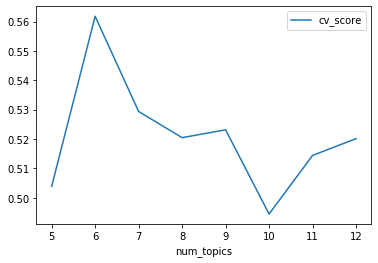

In [22]:
cv_df = pd.DataFrame(coherence_lda_scores, columns=['num_topics', 'cv_score'])
cv_df.plot(x='num_topics')

#### Sklearn LDA Model for finding the optimal number of topics

We perform a GridSearch over the parameter space of NUM_TOPICS and get the best cv score

In [23]:
review_optimised = []
for doc in review_no_sw:
    tokens = ""
    for token in doc:
        tokens = tokens + " " + token
    review_optimised.append(tokens[1:])

review_optimised[:5]

['update improvement',
 'mobile battery hell backup hour us idle lie amazon lenove battery charger hour',
 'cash',
 '',
 'phone everthey phone problem amazon phone amazon']

In [24]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(review_optimised)

In [25]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.646227472428943 %


In [26]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=12,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=12, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [27]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -359601.51317704853
Perplexity:  223.00993129887593
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 12,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [ ]:
# Define Search Param
search_params = {'n_components': range(5,13)}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

#### 10.1 Coherence of the optimal model

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

#### 11. Business interpretation of the identified topics

#### 11.1. Table with the topic names and the top 10 terms in each to present to the business